This notebook is meant to show the functionality of the `busworks` package, which can be found in: https://github.com/OZGrav/Torpedo/tree/master/slowcontrol/pyBusWorks/busworks.py. 

Most of this notebook requires that you have a TCP connection to an ACROMAG BusWorks XT1541-000, which in turn has its output ports connected to an oscilloscope.

# Importing packages

In [1]:
# Change this path to the folder where you have the file busworks.py
pybusworks_path = '/Users/dtoyra/work/git/ozgrav/Torpedo/slowcontrol/pyBusWorks'

import numpy as np
import matplotlib.pyplot as plt
import sys

# Importing busworks
sys.path.insert(0, pybusworks_path)
import busworks

# Calibrating

Showing how the busworks software can be calibrated. The data is DC voltage, measured by a multimeter (Agilent U1272A), and this is the data that this software originally was calibrated to.

The method `calibtate()` sets the obtained calibration parameters to bus.p.

Calibration result: n = 3000.2105762253614*V - 16.131301272760048 


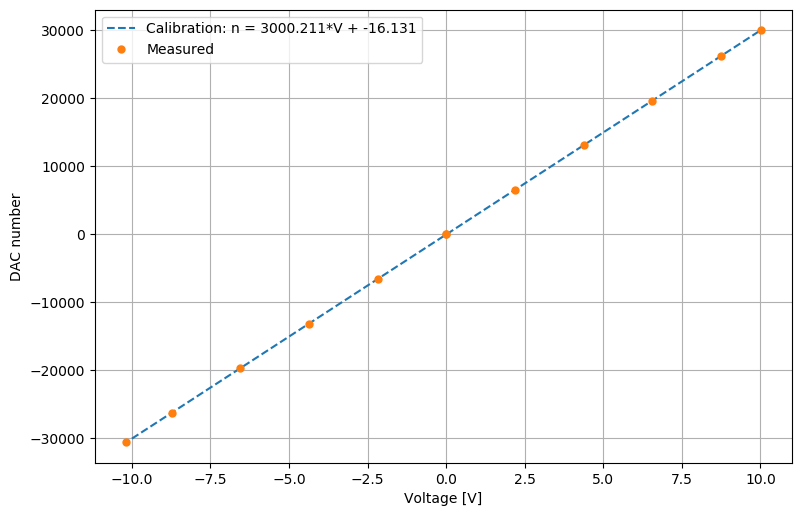

In [2]:
# Data used to calibrate the software.
V = np.array([-10.173, -8.732, -6.548, -4.363, -2.180, 4.8e-3, 5.4e-3, 2.190, 4.374, 6.558, 8.743, 10.005])
n = np.array([35000, 39321, 45874, 52428, 58981, 65535, 0, 6554, 13107, 19661, 26214, 30000])

# Creating an instance of BusWorks_DAC
bus = busworks.BusWorks_DAC()

# Calibrating
bus.calibrate(V, n, order=1)

# Before plotting, we offset the bins that yield negative voltage, to obtain a continous line.
n[n>32767] -= 65536

# Plotting
x = np.linspace(-10,10,100)
y = bus.p[0]*x + bus.p[1]
fig = plt.figure(dpi=100,figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(x,y, '--', markersize=6, label = 'Calibration: n = {0[0]:.3f}*V + {0[1]:.3f}'.format(bus.p))
ax.plot(V,n, '.', markersize=10, label = 'Measured')
ax.grid()
ax.set_xlabel('Voltage [V]')
ax.set_ylabel('DAC number')
ax.legend()
plt.show(fig)

# Looping sinus-functions

## One channel

In [3]:
# Amplitude [V], frequency [Hz], total loop-time [s], phase [deg], channel number [int], and sampling period [s],
A = 9
f = 3
T = 10
phi = 200
ch = 1
dt = 10e-3

bus = busworks.BusWorks_DAC()
bus.dt = dt
bus.start()
bus.loop_sinus(A, f, T, phi=phi, ch=ch)
bus.stop()

## Multiple channels

In [4]:
# Amplitude [V], frequency [Hz], total loop-time [s], phase [deg], channel number [int], and sampling period [s],
A = [9,3,7]
f = np.array([2,5,10])
T = 10
phi = np.array([0,0,0])
ch = 1
dt = 10e-3

bus = busworks.BusWorks_DAC()
bus.dt = dt
bus.start()
bus.loop_sinuses(A, f, T, phi, ch)
#   loop_sinuses(A, f, T, phi=phi, start_ch=1, dt=5e-3):
bus.stop()

# Looping user defined functions

Any array of data can be looped, here, two examples are shown.

## Stepping function

In [5]:
# Stepping between -10 and 10 for T seconds. It remains at each value for 5*bus.dt seconds before switching. 
A = np.ones(10)*10.0
A[5:] *= -1
T = 10
ch = 1

bus = busworks.BusWorks_DAC()
bus.dt = 10e-3
bus.start()
bus.loop_func(A, T, ch)
bus.stop()

In [6]:
# Same as above, but for multiple channels at once.
A = np.ones(10)*5.0
A[5:] *= -1

B = np.ones(24)*10.0
B[12:] *= -1

C = np.ones(30)*7.0
C[15:] *= -1

funcs = [A,B,C]

T = 10
start_ch = 1

bus = busworks.BusWorks_DAC()
bus.dt = 10e-3
bus.start()
bus.loop_funcs(funcs, T, start_ch)
bus.stop()

## Ramp

In [7]:
# Ramping from -10 to 10. 
A = np.linspace(-10,10,100)
T = 20
ch = 1

bus = busworks.BusWorks_DAC()
bus.dt = 10e-3
bus.start()
bus.loop_func(A, T, ch)
bus.stop()

# Setting and reading voltage

## 1 channel

In [8]:
V = 3
channel = 1

bus = busworks.BusWorks_DAC()
bus.start()
bus.set_voltage(V,channel)
regs = bus.read_registers(channel,1)

print(regs)
print(bus.int2V(regs))
print(bus.read_voltages(channel,1))

[8985]
[3.00016651]
[3.00016651]


## Multiple channels

In [9]:
Vs = [-5, 5, 10, 6]
start_channel = 1

bus = busworks.BusWorks_DAC()
bus.start()

bus.set_voltages(Vs, start_channel)
regs = bus.read_registers(start_channel,len(Vs))
volts = bus.read_voltages(start_channel, len(Vs))
bus.stop()

print('Input:  {0[0]:>37.4f} {0[1]:>8.4f} {0[2]:>8.4f} {0[3]:>8.4f}'.format(Vs))
print('Read registers: {0[0]:>28} {0[1]:>8} {0[2]:>8} {0[3]:>8}'.format(regs))
print(('Read registers converted to voltage: ' + 
       '{0[0]:>8.4f} {0[1]:>8.4f} {0[2]:>8.4f} {0[3]:>8.4f}').format(bus.int2V(regs)))
print('Read voltages: {0[0]:>30.4f} {0[1]:>8.4f} {0[2]:>8.4f} {0[3]:>8.4f}'.format(volts))

Input:                                -5.0000   5.0000  10.0000   6.0000
Read registers:                        50519    14985    29986    17985
Read registers converted to voltage:  -4.9999   5.0000  10.0000   6.0000
Read voltages:                        -4.9999   5.0000  10.0000   6.0000
